## 1. Data Acquisition 

We will start importing all the necessary libraries for this news sentiment analysis. 

In this step, we focused on retrieving relevant financial news articles and extracting sentiment information.

1. News Data Collection:
- We used the Google News API to scrape financial news articles related to:
  - S&P 500 performance
  - U.S. recession fears
  - U.S. economic downturn
- A total of 17,010 articles were collected over multiple search iterations.

2. Date Parsing & Cleaning:
- Articles often had relative timestamps (e.g., “2 days ago”). To handle this:
  - We implemented a date parsing function to convert relative dates into absolute timestamps.
  - Standardized the format using datetime.strptime().

3. Sentiment Analysis:
- We analyzed the title of each article using TextBlob to extract:
  - Sentiment polarity (ranging from -1 for negative to +1 for positive sentiment).
  - Sentiment subjectivity (ranging from 0 for objective to 1 for subjective content).

4. Finalizing the Dataset:
- The dataset was structured with columns: date, title, media, link, search_term, sentiment_polarity, and sentiment_subjectivity.
- We identified 38 missing values in the date column, which were handled accordingly.
- Finally, we exported the dataset to an Excel file (news_sentiment.xlsx) for later analysis.

This is our starting hypothesis: News sentiment related to U.S. recession fears and market performance has a measurable impact on S&P 500 movements.

In [2]:
from GoogleNews import GoogleNews
from textblob import TextBlob
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import time
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Function to parse and normalize dates
def parse_date(date_str):
    if not date_str or not isinstance(date_str, str):  # Handle missing or non-string values
        return None

    date_str = date_str.lower().strip()  # Normalize text
    parts = date_str.split()

    try:
        if "hour" in parts or "hours" in parts:
            return datetime.now() - timedelta(hours=int(parts[0]))
        elif "day" in parts or "days" in parts:
            return datetime.now() - timedelta(days=int(parts[0]))
        elif "week" in parts or "weeks" in parts:
            return datetime.now() - timedelta(weeks=int(parts[0]))
        elif "month" in parts or "months" in parts:
            return datetime.now() - timedelta(days=30 * int(parts[0]))  # Approximate
        elif "year" in parts or "years" in parts:
            return datetime.now() - timedelta(days=365 * int(parts[0]))  # Approximate
        else:
            return datetime.strptime(date_str, '%b %d, %Y')  # Handle standard date format
    except (ValueError, IndexError):
        return None  # Return None if parsing fails

# Initialize Google News
googlenews = GoogleNews(lang='en', region='US')

# Create a list of search items
search_terms = [
    "S&P 500 performance",
    "U.S. recession fears",
    "U.S. economic downturn"
]

# Create an empty list to store all the results
all_news = []

# Fetch news for each search term
for term in search_terms:
    googlenews.search(term)  # Perform search

    for page in range(1, 20):  # Fetch multiple pages
        googlenews.get_page(page)
        results = googlenews.results()

        # Process each article
        for article in results:
            title = article.get('title', '')

            # Perform sentiment analysis on the title
            blob = TextBlob(title)
            sentiment_polarity = blob.sentiment.polarity  # Ranges from -1 to 1
            sentiment_subjectivity = blob.sentiment.subjectivity  # Ranges from 0 to 1

            # Append article data to list
            all_news.append({
                'date': parse_date(article.get('date', '')),
                'title': title,
                'media': article.get('media', ''),
                'link': article.get('link', ''),
                'search_term': term,
                'sentiment_polarity': sentiment_polarity,
                'sentiment_subjectivity': sentiment_subjectivity
            })

        time.sleep(2)  # Time between requests to avoid rate limits

# Convert results into a DataFrame
news_df = pd.DataFrame(all_news)

print(news_df.columns)
print(news_df.shape)
display(news_df)

HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
Index(['date', 'title', 'media', 'link', 'search_term', 'sentiment_polarity',
       'sentiment_subjectivity'],
      dtype='object')
(17010, 7)


,date,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity
0,2025-03-04 08:27:13.516491,The Magnificent Seven won’t carry the S&P 500 ...,CTech,https://www.calcalistech.com/ctechnews/article...,S&P 500 performance,1.000000,1.000000
1,2025-03-03 17:27:13.516701,Magnificent Seven Stocks To Buy And Watch,Investor's Business Daily,https://www.investors.com/research/magnificent...,S&P 500 performance,1.000000,1.000000
2,2025-03-03 17:27:13.516826,Low Volatility leads as S&P 500 registers 1.3%...,Investing.com,https://www.investing.com/news/stock-market-ne...,S&P 500 performance,0.000000,0.300000
3,2025-03-01 17:27:13.516913,Bitcoin Performance Analysis Shows Strong Corr...,Nasdaq,https://www.nasdaq.com/articles/bitcoin-perfor...,S&P 500 performance,0.433333,0.733333
4,2025-03-01 17:27:13.517004,Ethereum's Stagnant Price Performance Compared...,Blockchain News,https://blockchain.news/flashnews/ethereum-s-s...,S&P 500 performance,0.000000,0.000000
...,...,...,...,...,...,...,...
17005,2024-09-05 17:31:15.767810,Are We in a Recession? Analyzing the Current E...,Business Insider,https://www.businessinsider.com/personal-finan...,U.S. economic downturn,0.100000,0.300000
17006,2024-09-05 17:31:15.767878,Goldman Sachs cuts odds of U.S. recession to 2...,CNBC,https://www.cnbc.com/2024/08/19/goldman-sachs-...,U.S. economic downturn,0.000000,0.000000
17007,2024-09-05 17:31:15.767932,Recession obsession: Why some people root for ...,MarketWatch,https://www.marketwatch.com/story/recession-ob...,U.S. economic downturn,0.200000,0.200000
17008,2024-09-05 17:31:15.767987,The probability of a recession now stands at 35%,J.P. Morgan,https://www.jpmorgan.com/insights/global-resea...,U.S. economic downturn,0.000000,0.000000


In [4]:
news_df['date'].describe()

count                            16972
mean     2024-12-16 07:15:17.306297344
min         2024-09-05 17:29:30.350854
25%      2024-11-04 17:28:37.332560640
50%      2025-01-03 17:29:38.857603072
75%      2025-02-02 17:30:56.960879616
max         2025-03-04 16:31:15.763307
Name: date, dtype: object

In [5]:
news_df.isna().sum()

date                      38
title                      0
media                      0
link                       0
search_term                0
sentiment_polarity         0
sentiment_subjectivity     0
dtype: int64

In [6]:
news_df.dtypes

date                      datetime64[ns]
title                             object
media                             object
link                              object
search_term                       object
sentiment_polarity               float64
sentiment_subjectivity           float64
dtype: object

In [7]:
# Export this dataframe to an excel file to work with it on another ocassion

# Determining the name of the file
file_name = 'news_sentiment.xlsx'

# saving the excel
news_df.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [21]:
news_df

,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity
date,,,,,,
2025-03-04 08:27:13.516491,The Magnificent Seven won’t carry the S&P 500 ...,CTech,https://www.calcalistech.com/ctechnews/article...,S&P 500 performance,1.000000,1.000000
2025-03-03 17:27:13.516701,Magnificent Seven Stocks To Buy And Watch,Investor's Business Daily,https://www.investors.com/research/magnificent...,S&P 500 performance,1.000000,1.000000
2025-03-03 17:27:13.516826,Low Volatility leads as S&P 500 registers 1.3%...,Investing.com,https://www.investing.com/news/stock-market-ne...,S&P 500 performance,0.000000,0.300000
2025-03-01 17:27:13.516913,Bitcoin Performance Analysis Shows Strong Corr...,Nasdaq,https://www.nasdaq.com/articles/bitcoin-perfor...,S&P 500 performance,0.433333,0.733333
2025-03-01 17:27:13.517004,Ethereum's Stagnant Price Performance Compared...,Blockchain News,https://blockchain.news/flashnews/ethereum-s-s...,S&P 500 performance,0.000000,0.000000
...,...,...,...,...,...,...
2024-09-05 17:31:15.767810,Are We in a Recession? Analyzing the Current E...,Business Insider,https://www.businessinsider.com/personal-finan...,U.S. economic downturn,0.100000,0.300000
2024-09-05 17:31:15.767878,Goldman Sachs cuts odds of U.S. recession to 2...,CNBC,https://www.cnbc.com/2024/08/19/goldman-sachs-...,U.S. economic downturn,0.000000,0.000000
2024-09-05 17:31:15.767932,Recession obsession: Why some people root for ...,MarketWatch,https://www.marketwatch.com/story/recession-ob...,U.S. economic downturn,0.200000,0.200000


In [34]:
currentTimeDate = datetime.now() - relativedelta(days=181) # Our news_df retrieves data as far back as 2024-09-05
start = currentTimeDate.strftime('%Y-%m-%d')
end = datetime.now().date() + timedelta(days = 1)

# Define 'SPY' as ticker symbol
ticker_symbol= 'SPY'

# Download historical data
spy = yf.download(ticker_symbol, start=start, end=end)

#Flatten the MultiIndex columns
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = ['_'.join(col).strip() for col in spy.columns.values]

spy.index.name = 'date'

display(spy)

[*********************100%***********************]  1 of 1 completed


,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
date,,,,,
2024-09-04,547.422852,550.880553,545.942400,546.677653,47224900
2024-09-05,546.091431,550.254609,543.597490,547.363265,44264300
2024-09-06,536.900574,548.068605,535.986481,546.419259,68493800
2024-09-09,542.911804,544.203530,539.205703,541.163123,40445800
2024-09-10,545.276672,545.634414,539.901333,544.849432,36394600
...,...,...,...,...,...
2025-02-26,594.539978,599.580017,591.859985,595.929993,43321600
2025-02-27,585.049988,598.020020,584.650024,596.849976,74196700
2025-02-28,594.179993,594.719971,582.440002,585.559998,88744100


In [36]:
# Merge the two dataframes based on the 'date' index

# Convert the 'date' index to date without time, so that merging won't encounter any issues
news_df.index = news_df.index.date

# Merge based on the 'date' index
merged_df = pd.merge(news_df, spy, how='inner', left_index= True, right_index= True)

print(merged_df.shape)

# Display head and tail of the new df
display(merged_df.head())
display(merged_df.tail())

(12108, 11)


,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
2025-03-04,The Magnificent Seven won’t carry the S&P 500 ...,CTech,https://www.calcalistech.com/ctechnews/article...,S&P 500 performance,1.0,1.0,575.596008,580.210022,572.250000,579.710022,40323707
2025-03-03,Magnificent Seven Stocks To Buy And Watch,Investor's Business Daily,https://www.investors.com/research/magnificent...,S&P 500 performance,1.0,1.0,583.770020,597.340027,579.900024,596.179993,73753300
2025-03-03,Low Volatility leads as S&P 500 registers 1.3%...,Investing.com,https://www.investing.com/news/stock-market-ne...,S&P 500 performance,0.0,0.3,583.770020,597.340027,579.900024,596.179993,73753300
2025-02-28,Weekly S&P 500 Index performance 2024,Statista,https://www.statista.com/statistics/1104270/we...,S&P 500 performance,0.0,0.0,594.179993,594.719971,582.440002,585.559998,88744100
2025-02-28,"Stock market today: Dow, S&P 500, Nasdaq slide...",Yahoo Finance,https://finance.yahoo.com/news/live/stock-mark...,S&P 500 performance,0.2,0.2,594.179993,594.719971,582.440002,585.559998,88744100


,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
2024-09-05,Are We in a Recession? Analyzing the Current E...,Business Insider,https://www.businessinsider.com/personal-finan...,U.S. economic downturn,0.1,0.3,546.091431,550.254609,543.59749,547.363265,44264300
2024-09-05,Goldman Sachs cuts odds of U.S. recession to 2...,CNBC,https://www.cnbc.com/2024/08/19/goldman-sachs-...,U.S. economic downturn,0.0,0.0,546.091431,550.254609,543.59749,547.363265,44264300
2024-09-05,Recession obsession: Why some people root for ...,MarketWatch,https://www.marketwatch.com/story/recession-ob...,U.S. economic downturn,0.2,0.2,546.091431,550.254609,543.59749,547.363265,44264300
2024-09-05,The probability of a recession now stands at 35%,J.P. Morgan,https://www.jpmorgan.com/insights/global-resea...,U.S. economic downturn,0.0,0.0,546.091431,550.254609,543.59749,547.363265,44264300
2024-09-05,"Even without a recession, a U.S. economic slow...",Quartz,https://qz.com/ubs-ceo-sergio-ermotti-slowdown...,U.S. economic downturn,0.2,0.2,546.091431,550.254609,543.59749,547.363265,44264300


In [38]:
merged_df.columns

Index(['title', 'media', 'link', 'search_term', 'sentiment_polarity',
       'sentiment_subjectivity', 'Close_SPY', 'High_SPY', 'Low_SPY',
       'Open_SPY', 'Volume_SPY'],
      dtype='object')

In [39]:
final_df = merged_df[['sentiment_polarity', 'sentiment_subjectivity', 'Close_SPY', 'search_term']]

In [40]:
final_df

,sentiment_polarity,sentiment_subjectivity,Close_SPY,search_term
2025-03-04,1.0,1.0,575.596008,S&P 500 performance
2025-03-03,1.0,1.0,583.770020,S&P 500 performance
2025-03-03,0.0,0.3,583.770020,S&P 500 performance
2025-02-28,0.0,0.0,594.179993,S&P 500 performance
2025-02-28,0.2,0.2,594.179993,S&P 500 performance
...,...,...,...,...
2024-09-05,0.1,0.3,546.091431,U.S. economic downturn
2024-09-05,0.0,0.0,546.091431,U.S. economic downturn
2024-09-05,0.2,0.2,546.091431,U.S. economic downturn
2024-09-05,0.0,0.0,546.091431,U.S. economic downturn


In [70]:
# Filter for relevant significant sentiment polarity or subjectivity, so we reduce noise in our dataset
relevant_events = merged_df.query("abs(sentiment_polarity) > 0.02 or abs(sentiment_subjectivity) > 0.02")

In [71]:
relevant_events

,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
2025-03-04,The Magnificent Seven won’t carry the S&P 500 ...,CTech,https://www.calcalistech.com/ctechnews/article...,S&P 500 performance,1.00,1.000000,575.596008,580.210022,572.250000,579.710022,40323707
2025-03-03,Magnificent Seven Stocks To Buy And Watch,Investor's Business Daily,https://www.investors.com/research/magnificent...,S&P 500 performance,1.00,1.000000,583.770020,597.340027,579.900024,596.179993,73753300
2025-03-03,Low Volatility leads as S&P 500 registers 1.3%...,Investing.com,https://www.investing.com/news/stock-market-ne...,S&P 500 performance,0.00,0.300000,583.770020,597.340027,579.900024,596.179993,73753300
2025-02-28,"Stock market today: Dow, S&P 500, Nasdaq slide...",Yahoo Finance,https://finance.yahoo.com/news/live/stock-mark...,S&P 500 performance,0.20,0.200000,594.179993,594.719971,582.440002,585.559998,88744100
2025-02-27,S&P 500 ends barely changed; Nvidia shares up ...,Reuters,https://www.reuters.com/markets/us/futures-up-...,S&P 500 performance,0.05,0.100000,585.049988,598.020020,584.650024,596.849976,74196700
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04,How A Soft Landing Could Impact US Commercial ...,Altus Group,https://www.altusgroup.com/insights/how-a-soft...,U.S. economic downturn,0.10,0.216667,567.898621,570.579600,565.985078,569.264020,38217000
2024-11-04,The U.S. Economy Performs Better Under Democra...,Joint Economic Committee (.gov),https://www.jec.senate.gov/public/index.cfm/de...,U.S. economic downturn,0.50,0.500000,567.898621,570.579600,565.985078,569.264020,38217000
2024-09-05,Are We in a Recession? Analyzing the Current E...,Business Insider,https://www.businessinsider.com/personal-finan...,U.S. economic downturn,0.10,0.300000,546.091431,550.254609,543.597490,547.363265,44264300
2024-09-05,Recession obsession: Why some people root for ...,MarketWatch,https://www.marketwatch.com/story/recession-ob...,U.S. economic downturn,0.20,0.200000,546.091431,550.254609,543.597490,547.363265,44264300


## 2. EDA Analysis

In this exploratory data analysis, we investigated the relationship between news sentiment 
and SPY closing prices. We first analyzed summary statistics to understand the distribution 
of sentiment polarity, subjectivity, and stock prices. 

We then visualized SPY closing prices over time to observe trends and potential shifts.
A correlation matrix was generated to measure relationships between sentiment scores 
and SPY prices, revealing weak correlations.

To enhance our model, we introduced lagged SPY prices and moving averages to capture 
historical price trends. This improved our predictive modeling, as shown in feature 
importance analysis, where past SPY prices had a greater impact than sentiment data.

Key Findings:
- Sentiment polarity and subjectivity alone are weak predictors of SPY prices.
- Historical SPY prices and moving averages improve model performance.
- Further feature engineering and alternative sentiment sources (e.g., social media) 
  could enhance predictability.

In [72]:
display(relevant_events.describe())

,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
count,6747.000000,6747.000000,6747.000000,6747.000000,6747.000000,6747.000000,6.747000e+03
mean,0.224874,0.470125,581.957302,584.750739,578.189103,581.632651,4.401273e+07
std,0.371035,0.270340,19.893123,18.960041,19.182607,18.759309,1.190295e+07
min,-1.000000,0.000000,546.091431,550.254609,543.597490,547.363265,2.674900e+07
25%,0.000000,0.287500,567.898621,570.579600,565.985078,569.264020,3.788850e+07
50%,0.160000,0.428571,591.950012,592.599976,586.429993,587.530029,3.821700e+07
75%,0.400000,0.600000,591.950012,597.890015,586.429993,596.179993,4.426430e+07
max,1.000000,1.000000,611.489990,611.489990,608.380005,610.880005,8.874410e+07


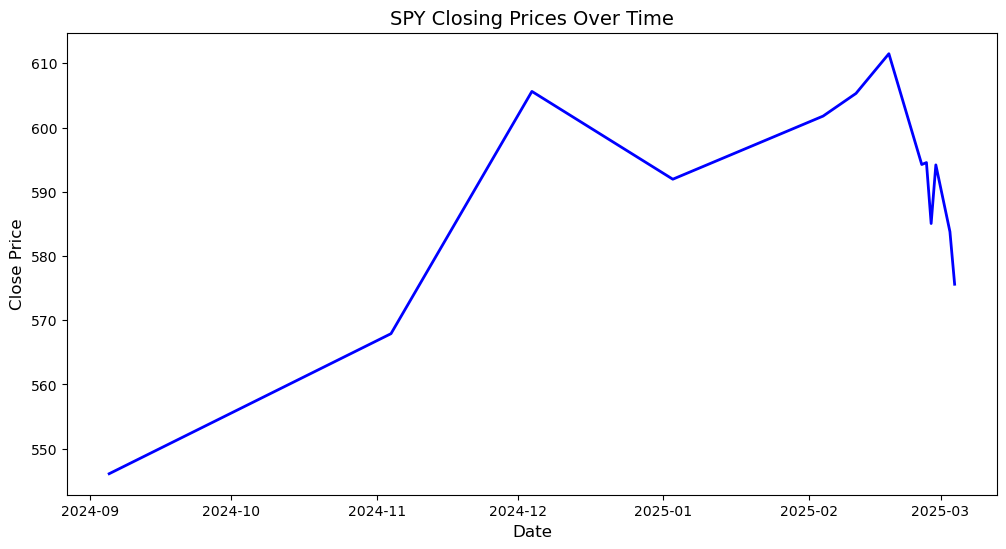

In [91]:
# Create figure
plt.figure(figsize=(12,6))

# Plot line chart with Seaborn
sns.lineplot(data=aggregated_df, x=aggregated_df.index, y='Close_SPY', color='blue', linewidth=2)

# Labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.title("SPY Closing Prices Over Time", fontsize=14)

# Show the plot
plt.show()

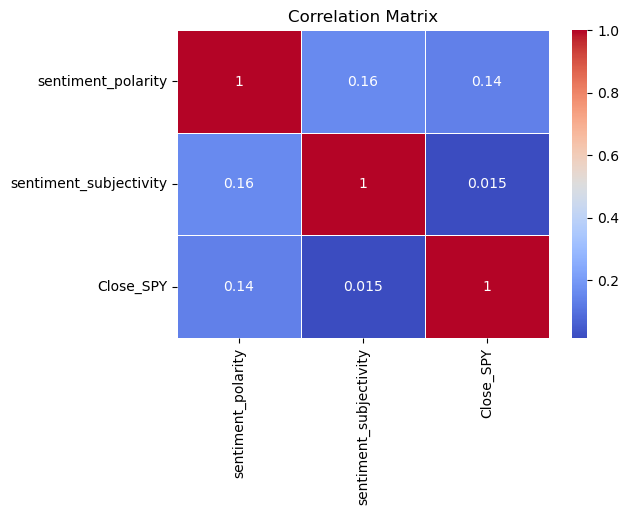

In [76]:
corr_matrix = relevant_events[['sentiment_polarity', 'sentiment_subjectivity', 'Close_SPY']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

There is some correlation between sentiment_polarity, sentiment_subjectivity, and Close_SPY, but it is weak (correlation values around 0.14 and 0.11).
- Weak correlation suggests that sentiment alone may not be a strong predictor of SPY prices.
- We should consider adding more features like lagged SPY prices, moving averages, or volume could improve the model.

In [77]:
# Create lag features (previous closing prices) for SPY
relevant_events['Close_SPY_lag_1'] = relevant_events['Close_SPY'].shift(1)
relevant_events['Close_SPY_lag_3'] = relevant_events['Close_SPY'].shift(3)

# Create rolling averages (moving averages) for SPY
relevant_events['Close_SPY_7D_MA'] = relevant_events['Close_SPY'].rolling(window=7).mean()
relevant_events['Close_SPY_14D_MA'] = relevant_events['Close_SPY'].rolling(window=14).mean()

# Drop rows with NaN values due to lagging
relevant_events = relevant_events.dropna()

print(relevant_events.shape)
display(relevant_events.head())
display(relevant_events.tail())

(6734, 15)


/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_6123/265946318.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_6123/265946318.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_6123/265946318.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Close_SPY_lag_1,Close_SPY_lag_3,Close_SPY_7D_MA,Close_SPY_14D_MA
2025-03-03,Magnificent Seven Stocks To Buy And Watch,Investor's Business Daily,https://www.investors.com/research/magnificent...,S&P 500 performance,1.00,1.0,583.770020,597.340027,579.900024,596.179993,73753300,575.596008,585.049988,584.455148,583.871290
2025-03-03,Low Volatility leads as S&P 500 registers 1.3%...,Investing.com,https://www.investing.com/news/stock-market-ne...,S&P 500 performance,0.00,0.3,583.770020,597.340027,579.900024,596.179993,73753300,583.770020,585.049988,584.455148,584.455148
2025-02-28,"Stock market today: Dow, S&P 500, Nasdaq slide...",Yahoo Finance,https://finance.yahoo.com/news/live/stock-mark...,S&P 500 performance,0.20,0.2,594.179993,594.719971,582.440002,585.559998,88744100,583.770020,575.596008,585.942287,585.198717
2025-02-27,S&P 500 ends barely changed; Nvidia shares up ...,Reuters,https://www.reuters.com/markets/us/futures-up-...,S&P 500 performance,0.05,0.1,585.049988,598.020020,584.650024,596.849976,74196700,594.179993,583.770020,584.638000,585.290144
2025-02-27,"Markets News, February 26, 2025: S&P 500, Nasd...",Investopedia,https://www.investopedia.com/dow-jones-today-0...,S&P 500 performance,0.25,0.5,585.049988,598.020020,584.650024,596.849976,74196700,585.049988,583.770020,584.638000,584.638000


,title,media,link,search_term,sentiment_polarity,sentiment_subjectivity,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Close_SPY_lag_1,Close_SPY_lag_3,Close_SPY_7D_MA,Close_SPY_14D_MA
2024-11-04,How A Soft Landing Could Impact US Commercial ...,Altus Group,https://www.altusgroup.com/insights/how-a-soft...,U.S. economic downturn,0.1,0.216667,567.898621,570.579600,565.985078,569.264020,38217000,567.898621,567.898621,580.159450,589.711870
2024-11-04,The U.S. Economy Performs Better Under Democra...,Joint Economic Committee (.gov),https://www.jec.senate.gov/public/index.cfm/de...,U.S. economic downturn,0.5,0.500000,567.898621,570.579600,565.985078,569.264020,38217000,567.898621,567.898621,576.723537,587.830344
2024-09-05,Are We in a Recession? Analyzing the Current E...,Business Insider,https://www.businessinsider.com/personal-finan...,U.S. economic downturn,0.1,0.300000,546.091431,550.254609,543.597490,547.363265,44264300,567.898621,567.898621,570.172311,583.159018
2024-09-05,Recession obsession: Why some people root for ...,MarketWatch,https://www.marketwatch.com/story/recession-ob...,U.S. economic downturn,0.2,0.200000,546.091431,550.254609,543.597490,547.363265,44264300,546.091431,567.898621,561.667995,578.487693
2024-09-05,"Even without a recession, a U.S. economic slow...",Quartz,https://qz.com/ubs-ceo-sergio-ermotti-slowdown...,U.S. economic downturn,0.2,0.200000,546.091431,550.254609,543.597490,547.363265,44264300,546.091431,567.898621,558.552682,574.509936


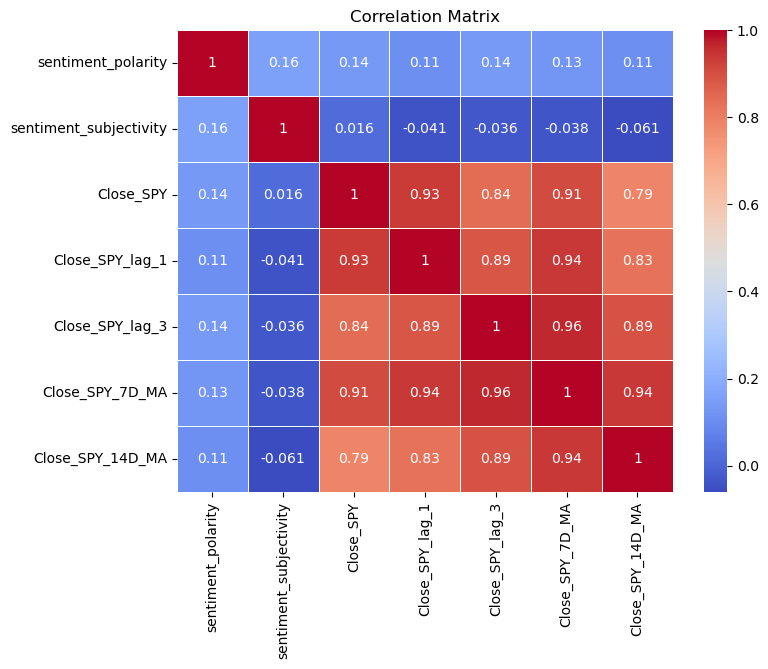

In [78]:
corr_matrix = relevant_events[['sentiment_polarity', 'sentiment_subjectivity', 
                        'Close_SPY', 'Close_SPY_lag_1',	'Close_SPY_lag_3',	
                        'Close_SPY_7D_MA', 'Close_SPY_14D_MA']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## 3. Building and Evaluating Machine Learning Models

On this part of the project, we built and evaluated machine learning models to predict SPY closing prices using sentiment polarity, subjectivity, and past price movements.

1. Initial Model Testing
- We started with a Random Forest Regressor to establish a baseline.
- Key performance metrics: R² Score: 0.99, Mean Squared Error (MSE): 3.58.

2. Feature Importance Analysis
- We analyzed the contribution of each feature to model predictions.
- The previous day’s SPY closing price (Close_SPY_lag_1) was the most important predictor, followed by sentiment polarity and subjectivity.

3. Hyperparameter Tuning
- We performed Grid Search Cross-Validation to optimize the Random Forest model.
- Best parameters: 200 estimators, min_samples_split=5, min_samples_leaf=1, max_depth=None.

4. Model Validation with Cross-Validation
- We evaluated the tuned model using 5-fold cross-validation.
- The average R² Score remained high (0.9789), confirming model reliability.

In [87]:
# Set your Features(x) and target(y) variable for machine learning exploration
X = relevant_events[['sentiment_polarity', 'sentiment_subjectivity', 'Close_SPY_lag_1']]
y = relevant_events['Close_SPY']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

R^2 Score: 0.9909405332162912
Mean Squared Error: 3.587747212406245


/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_6123/2888566570.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




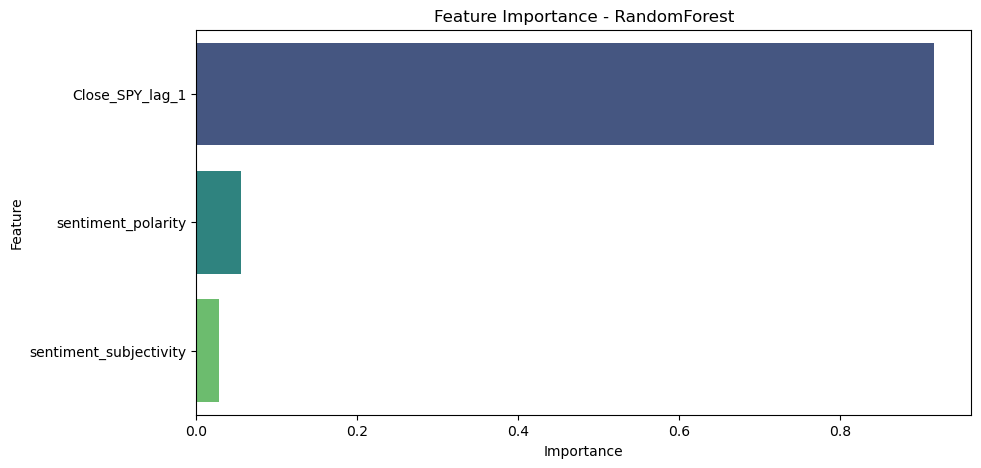

In [88]:
# Get feature importance from the trained model
feature_importance = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance - RandomForest")
plt.show()

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model to predict
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Optimized R^2 Score: {r2}")
print(f"Optimized Mean Squared Error: {mse}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Optimized R^2 Score: 0.9909547380469249
Optimized Mean Squared Error: 3.582121788446319


In [90]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean R^2 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of R^2 Scores: {cv_scores.std():.4f}")

Cross-Validation R^2 Scores: [0.94679313 0.97883832 0.98822224 0.99050397 0.99018098]
Mean R^2 Score: 0.9789
Standard Deviation of R^2 Scores: 0.0166
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, m

1.	Sentiment Polarity and Subjectivity Impact:
- While sentiment polarity and subjectivity had some influence, their correlation with SPY closing prices was relatively weak (around 0.14).
- This suggests that sentiment alone is not a strong predictor of market movements.
2. Historical Prices as the Strongest Predictor:
- The most significant feature in the model was the previous day’s SPY closing price (Close_SPY_lag_1), indicating that historical stock prices are far more predictive of future prices than sentiment metrics.
- This aligns with the efficient market hypothesis, which suggests that stock prices already reflect all available information.
3. Random Forest Model Performance:
- After hyperparameter tuning, our Random Forest model achieved an R² of ~0.99, showing that the model accurately predicts SPY closing prices but primarily based on historical prices, rather than sentiment factors.

4. Conclusion
- While negative sentiment may influence market behavior in specific cases, our model does not show strong evidence that sentiment polarity and subjectivity directly drive SPY price changes.
- Instead, historical stock prices remain the dominant factor in predicting future movements, suggesting that traders rely more on past trends than media sentiment alone.